# Data Exploration

The data provided for this challenge is divided in the following manner:

 + Training set: 50,000 samples
 + Validation set: 50,000 samples
 + Test set: 100,000 samples

There are 1,000 possible labels, and each image can have up to 5 objects in it.

### Sample images

In [14]:
sample_images_path = 'sample-images/'
sample_images = ['n04005630_78665.JPEG', 'n02012849_9910.JPEG', 'n01677366_13449.JPEG', 'n04447861_3856.JPEG']

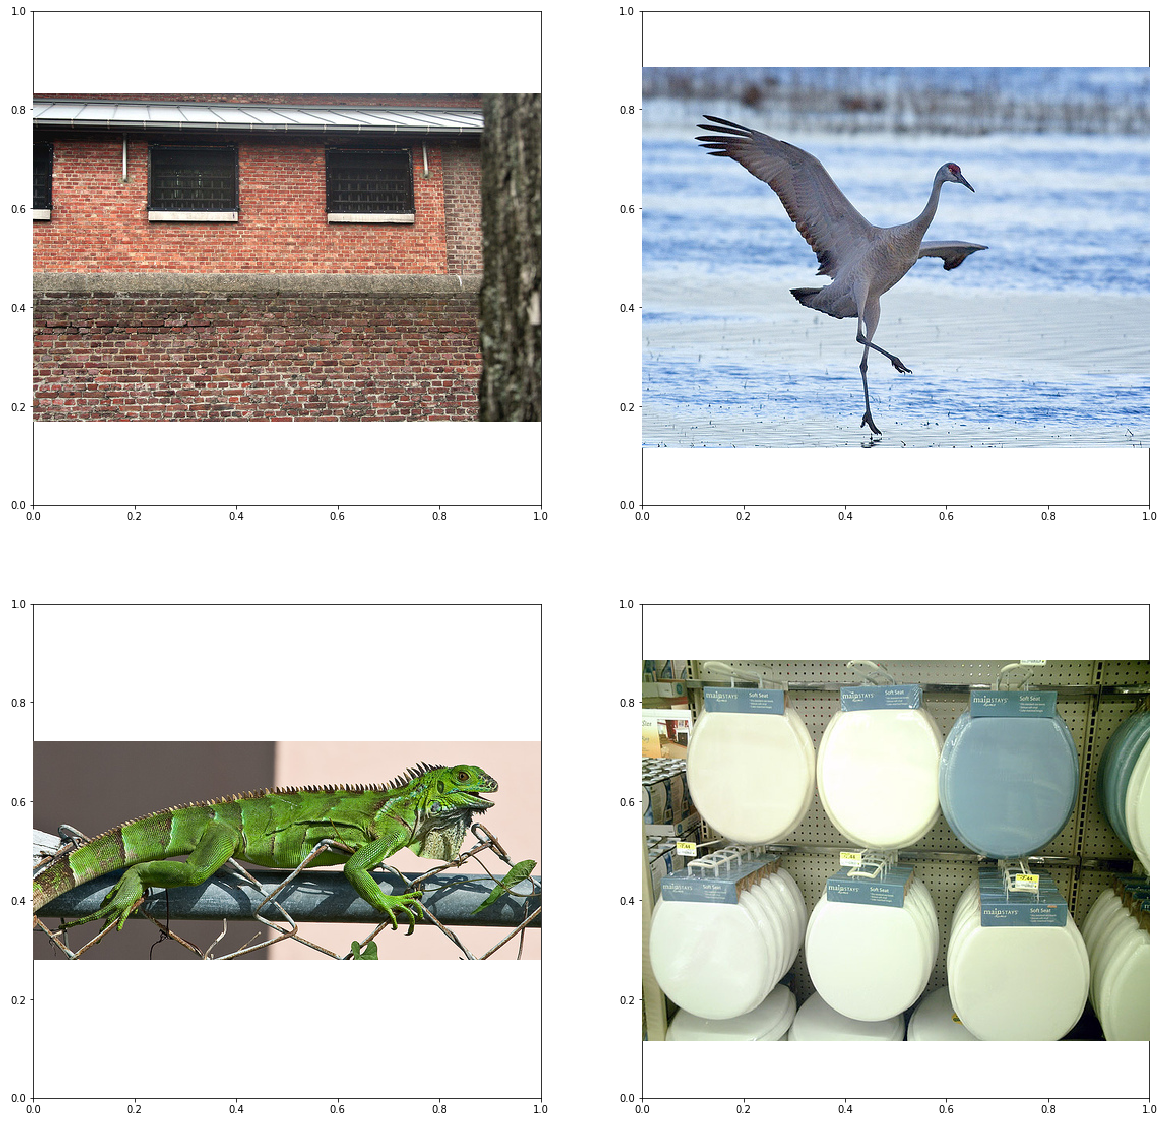

In [15]:
import matplotlib.pyplot as plt

plt.close('all')
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for index, sample_img in enumerate(sample_images):
    ax = fig.add_subplot(2, 2, index + 1)
    ax.imshow(plt.imread(sample_images_path + sample_img))
    ax.axis('off')
fig

### Labels

The training an validation sets are labeled such that each sample image contains zero (none) or more (up to five) bounding boxes describing where the object is in the image, as well as what that object is. Each sample is labeled in the following format:

 + ImageId - the ID of the sample image
 + Width - width of the image (in pixels)
 + Height - height of the image (in pixels)
 + PredictionString - a set of zero of more groups of five values, representing:
     + synsetId - the synset ID of the object in the image
     + x_min - left coordinate of the top left corner (in pixels) of the bounding box where the object in the image
     + y_min - top coordinate of the top left corner (in pixels) of the bounding box where the object in the
     + x_max - right coordinate of the bottom right corner (in pixels) of the bounding box where the object in the image
     + y_max - bottom coordinate of the bottom right corner (in pixels) of the bounding box where the object in the

In [16]:
import pandas as pd

In [17]:
loc_train_solution = pd.read_csv('LOC_train_solution_with_size.csv')
loc_val_solution = pd.read_csv('LOC_val_solution_with_size.csv')
loc_sample_images = pd.read_csv('sample_images.csv')
loc_synset_mapping_path = 'LOC_synset_mapping.txt'

In [18]:
loc_sample_images.head()

,ImageId,Width,Height,PredictionString
0,n04005630_78665,500,324,n04005630 0 0 499 323
1,n02012849_9910,500,376,n02012849 50 46 345 366
2,n04447861_3856,500,375,n04447861 42 24 170 186 n04447861 292 28 430 1...
3,n01677366_13449,500,216,n01677366 0 19 459 202
4,n01983481_17635,500,333,n01983481 34 137 255 264


In [19]:
loc_train_solution.head()

,ImageId,Width,Height,PredictionString
0,n02017213_7894,500,334,n02017213 115 49 448 294
1,n02017213_7261,400,500,n02017213 91 42 330 432
2,n02017213_5636,500,341,n02017213 230 104 414 224
3,n02017213_6132,500,438,n02017213 46 82 464 387
4,n02017213_7659,333,500,n02017213 103 66 331 335


In [20]:
loc_val_solution.head()

,ImageId,Width,Height,PredictionString
0,ILSVRC2012_val_00048981,500,360,n03995372 85 1 499 272
1,ILSVRC2012_val_00037956,500,333,n03481172 131 0 499 254
2,ILSVRC2012_val_00026161,500,334,n02108000 38 0 464 280
3,ILSVRC2012_val_00026171,225,300,n03109150 0 14 216 299
4,ILSVRC2012_val_00008726,500,357,n02119789 255 142 454 329 n02119789 44 21 322 295


### Bounding boxes as percentages

Since we'll be using TensorFlow for this, we'll use [tf.image.draw_bounding_boxes](https://www.tensorflow.org/api_docs/python/tf/image/draw_bounding_boxes) to see the bounding boxes during training and at inference. Since that API requires the values for `[x_min, y_min, x_max, y_max]` to be floats in `[0.0, 1.0]` relative to the width and height of each image, we'll need to convert those values from absolute pixels to percentages.

In [21]:
def expand_prediction_cell(df, colname):
    """Expands all the space separated values in a column into separate columns.
    The assumption is that the column to be expanded is the right-most one.
    Also, since the 5 values being expanded are label, x min, y min, x max, y max,
    those groups will also be put under column names that represent that more explicitly.
    """
    df = df[df.columns[:-1]].join(df[colname].str.split(' ', expand=True))
    
    renamed_cols = list(df.columns[3:])
    labels = ['lb', 'xmin', 'ymin', 'xmax', 'ymax']

    for i in range(int(len(renamed_cols) / 5)):
        renamed_cols[i*5:i*5+5] = [lb + str(i) for lb in labels]
    
    df.columns=list(df.columns[0:3]) + renamed_cols
    num_cols = (df.columns.shape[0] - 3) // 5
    for i in range(num_cols):
        df['xmin{}'.format(i)] = df['xmin{}'.format(i)].astype(float) / df.Width.astype(int)
        df['ymin{}'.format(i)] = df['ymin{}'.format(i)].astype(float) / df.Height.astype(int)
        df['xmax{}'.format(i)] = df['xmax{}'.format(i)].astype(float) / df.Width.astype(int)
        df['ymax{}'.format(i)] = df['ymax{}'.format(i)].astype(float) / df.Height.astype(int)
    
    return df


In [22]:
loc_sample_images_xp = expand_prediction_cell(loc_sample_images, 'PredictionString')
print(loc_sample_images_xp.dtypes)
loc_sample_images_xp.head()

ImageId     object
Width        int64
Height       int64
lb0         object
xmin0      float64
ymin0      float64
xmax0      float64
ymax0      float64
lb1         object
xmin1      float64
ymin1      float64
xmax1      float64
ymax1      float64
lb2         object
xmin2      float64
ymin2      float64
xmax2      float64
ymax2      float64
lb3         object
xmin3      float64
ymin3      float64
xmax3      float64
ymax3      float64
lb4         object
xmin4      float64
ymin4      float64
xmax4      float64
ymax4      float64
lb5         object
xmin5      float64
ymin5      float64
xmax5      float64
ymax5      float64
dtype: object


,ImageId,Width,Height,lb0,xmin0,ymin0,xmax0,ymax0,lb1,xmin1,...,lb4,xmin4,ymin4,xmax4,ymax4,lb5,xmin5,ymin5,xmax5,ymax5
0,n04005630_78665,500,324,n04005630,0.000,0.000000,0.998,0.996914,None,NaN,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,n02012849_9910,500,376,n02012849,0.100,0.122340,0.690,0.973404,None,NaN,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,n04447861_3856,500,375,n04447861,0.084,0.064000,0.340,0.496000,n04447861,0.584,...,n04447861,0.32,0.52,0.588,0.952,n04447861,0.006,0.570667,0.27,0.949333
3,n01677366_13449,500,216,n01677366,0.000,0.087963,0.918,0.935185,None,NaN,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
4,n01983481_17635,500,333,n01983481,0.068,0.411411,0.510,0.792793,None,NaN,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


### Synset mapping

The labels above are synset IDs, which we'll want to map to the their corresponding English values. Using the function `parse_synset_mapping()`, we'll have a dict that maps the synset ID to a list of values for that synset. Also, since we'll need to convert each synset ID to an integer, we'll need to generate another map to help with that.

In [23]:
def parse_synset_mapping(path):
    """Parse the synset mapping file into a dictionary mapping <synset_id>:[<synonyms in English>]
    This assumes an input file formatted as:
        <synset_id> <category>, <synonym...>
    Example:
        n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
    """
    synset_map = {}
    with open(path, 'r') as fp:
        lines = fp.readlines()
        for line in lines:
            parts = line.split(' ')
            synset_map[parts[0]] = [label.strip() for label in ' '.join(parts[1:]).split(',')]
        return synset_map
    
def generate_synset_to_int_mapping(synset_mapping):
    synset_to_int_map = {}
    for index, (key, val) in enumerate(synset_mapping.items()):
        synset_to_int_map[key] = index
    return synset_to_int_map
    
def generate_int_to_synset_mapping(synset_mapping):
    int_to_synset_map = {}
    for index, (key, val) in enumerate(synset_mapping.items()):
        int_to_synset_map[index] = key
    return int_to_synset_map

In [24]:
synset_mapping = parse_synset_mapping(loc_synset_mapping_path)
synset_to_int = generate_synset_to_int_mapping(synset_mapping)
int_to_synset = generate_int_to_synset_mapping(synset_mapping)

In [25]:
len(synset_mapping)

1000

In [26]:
for index, (key, val) in enumerate(synset_mapping.items()):
    if (index > 5):
        break
    print('{} {}'.format(key, val))

n01440764 ['tench', 'Tinca tinca']
n01443537 ['goldfish', 'Carassius auratus']
n01484850 ['great white shark', 'white shark', 'man-eater', 'man-eating shark', 'Carcharodon carcharias']
n01491361 ['tiger shark', 'Galeocerdo cuvieri']
n01494475 ['hammerhead', 'hammerhead shark']
n01496331 ['electric ray', 'crampfish', 'numbfish', 'torpedo']


In [27]:
for index, (key, val) in enumerate(synset_to_int.items()):
    if (index > 5):
        break
    print('{} {}'.format(key, val))

n01440764 0
n01443537 1
n01484850 2
n01491361 3
n01494475 4
n01496331 5


In [28]:
for index, (key, val) in enumerate(int_to_synset.items()):
    if (index > 5):
        break
    print('{} {}'.format(key, val))

0 n01440764
1 n01443537
2 n01484850
3 n01491361
4 n01494475
5 n01496331


### Stats

Let's explore the training set a bit.

In [91]:
training_set = expand_prediction_cell(loc_train_solution, 'PredictionString')

(544546,)

In [130]:
rows = training_set.lb0.shape[0]
cols = 17
for i in range(cols):
    print('Records with at least {} box{}: {}'.format(i + 1, 'es' if i > 0 else '', rows - training_set['lb{}'.format(i)].isnull().sum(axis=0)))
print(training_set[training_set.lb16.notnull()])

Records with at least 1 box: 544546
Records with at least 2 boxes: 50282
Records with at least 3 boxes: 12683
Records with at least 4 boxes: 4636
Records with at least 5 boxes: 1905
Records with at least 6 boxes: 763
Records with at least 7 boxes: 240
Records with at least 8 boxes: 115
Records with at least 9 boxes: 58
Records with at least 10 boxes: 33
Records with at least 11 boxes: 12
Records with at least 12 boxes: 9
Records with at least 13 boxes: 6
Records with at least 14 boxes: 4
Records with at least 15 boxes: 3
Records with at least 16 boxes: 2
Records with at least 17 boxes: 2
                ImageId  Width  Height        lb0     xmin0     ymin0  \
346403  n07745940_12455    140     208  n07745940  0.200000  0.216346   
346671   n07745940_3501    263     314  n07745940  0.140684  0.773885   

           xmax0     ymax0        lb1     xmin1    ...          lb15  \
346403  0.307143  0.283654  n07745940  0.235714    ...     n07745940   
346671  0.235741  0.872611  n07745940  0.

### Putting it all together

Now we're ready to draw some bounding boxes to ensure that the above transformations were done correctly.

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Session has been closed.
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Session has been closed.
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Session has been closed.
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Session has been closed.


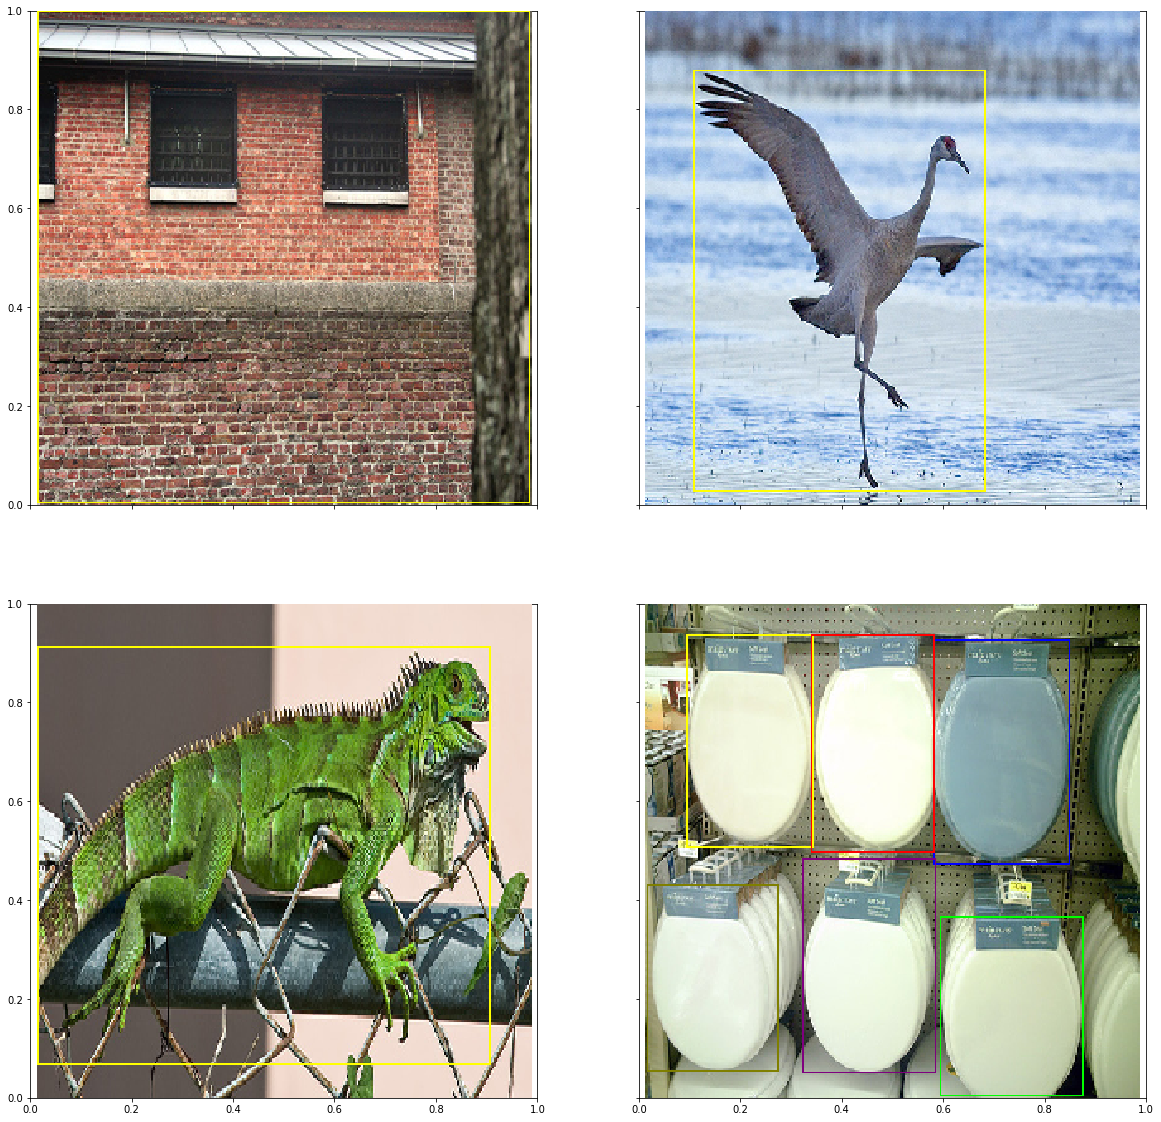

In [78]:
import tensorflow as tf
from PIL import Image
import numpy as np

def draw(img, sample_images_path, sample_img, img_col, fig, index=0):
    img_path = sample_images_path + sample_img
    filename = sample_img.split('.')[0]
    row = img_col.loc[img_col['ImageId'] == filename]
    synset = row.ImageId.values[0].split('_')[0]

    img_name = [img_path]
#     filename_queue = tf.train.string_input_producer(img_name)
#     img_reader = tf.WholeFileReader()
#     _,image_jpg = img_reader.read(filename_queue)

#     image_decode_jpeg = tf.image.decode_jpeg(image_jpg)
#     image_decode_jpeg = tf.image.convert_image_dtype(image_decode_jpeg, dtype=tf.float32)
#     img = image_decode_jpeg
#     image_decode_jpeg = tf.expand_dims(image_decode_jpeg, 0)

    sess = tf.Session()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    boxes = []
    num_cols = (row.columns.shape[0] - 3) // 5
    
    for i in range(num_cols):
        if row['lb{}'.format(i)].values[0] is not None:
            boxes.append([
                row['ymin{}'.format(i)].values[0],
                row['xmin{}'.format(i)].values[0],
                row['ymax{}'.format(i)].values[0],
                row['xmax{}'.format(i)].values[0]])
#     boxes = [[row.ymin0.values[0], row.xmin0.values[0], row.ymax0.values[0], row.xmax0.values[0]]]
    box = tf.constant([boxes])
    img = tf.convert_to_tensor(img)
    img = tf.reshape(img, [1, 299, 299, 3])

    image_bilinear = tf.image.draw_bounding_boxes(img, box)
    image_bilinear = tf.reshape(image_bilinear, [299, 299, 3])

    ax = fig.add_subplot(2, 2, index + 1)
    ax.imshow(sess.run(image_bilinear))
    ax.axis('off')
    sess.close()

plt.close('all')
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(20, 20))
for index, sample_img in enumerate(sample_images):
    img = Image.open(sample_images_path + sample_img)
    img = np.array(img.resize((299, 299))) / 255
    img = img.astype(np.float32)
    draw(img, sample_images_path, sample_img, loc_sample_images_xp, fig, index)
fig